In [17]:
# standard scaler 
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# 경로 설정
csv_folders = [
    Path("C:/Users/Developer/TCLab/csv/data_back3"),
    Path("C:/Users/Developer/TCLab/csv/data_back4"),
    Path("C:/Users/Developer/TCLab/csv/data_back5"),
    Path("C:/Users/Developer/TCLab/csv/data_back6"),
]

all_observations = []
all_actions = []
all_next_observations = []
raw_rewards = []
all_dones = []

alpha = 0.05  # 시간 패널티 계수
dt = 5.0      # 샘플 간격 (초)

for folder in csv_folders:
    csv_files = sorted(folder.glob("mpc_episode_*_data.csv"))
    for file in csv_files:
        df = pd.read_csv(file)
        for i in range(len(df) - 1):
            curr = df.iloc[i]
            next_ = df.iloc[i + 1]

            state = [curr["T1"], curr["T2"], curr["TSP1"], curr["TSP2"]]
            action = [curr["Q1"], curr["Q2"]]
            next_state = [next_["T1"], next_["T2"], next_["TSP1"], next_["TSP2"]]

            # 에러 및 시간
            # error1 = next_["TSP1"] - next_["T1"]
            # error2 = next_["TSP2"] - next_["T2"]
            # time_sec = i * dt

            # # 시간 기반 리워드
            # reward = -np.sqrt(error1**2 + error2**2) - alpha * time_sec
            error1 = curr["TSP1"] - curr["T1"]
            error2 = curr["TSP2"] - curr["T2"]
            reward = - np.sqrt(error1**2 + error2 ** 2)
            #reward = -np.sqrt(error1**2+ error2**2) 
            raw_rewards.append(reward)

            done = (i == len(df) - 2)
            

            all_observations.append(state)
            all_actions.append(action)
            all_next_observations.append(next_state)
            all_dones.append(done)

# ⭐️ 리워드 표준화
scaler = StandardScaler()
scaled_rewards = scaler.fit_transform(np.array(raw_rewards).reshape(-1, 1)).flatten()
import joblib
joblib.dump(scaler, "first_reward.pkl")
# 데이터셋 저장
dataset = {
    "observations": np.array(all_observations, dtype=np.float32),
    "actions": np.array(all_actions, dtype=np.float32),
    "next_observations": np.array(all_next_observations, dtype=np.float32),
    "rewards": scaled_rewards.astype(np.float32),
    "terminals": np.array(all_dones, dtype=bool),
}
# 추가 디버깅 출력
acts = dataset['actions']
print("[Debug] Action range in dataset:", acts.min(), "~", acts.max())
print("[Debug] Action mean:", acts.mean(axis=0), "std:", acts.std(axis=0))

rewards = dataset['rewards']
print("[Debug] rewards range in dataset:", scaled_rewards.min(), "~", scaled_rewards.max())
print("[Debug] rewards mean:", scaled_rewards.mean(axis=0), "std:", scaled_rewards.std(axis=0))

observations = dataset['observations']
print("[Debug] observations range in dataset:", observations.min(), "~", observations.max())
print("[Debug] observations mean:", observations.mean(axis=0), "std:", observations.std(axis=0))
output_path = "C:/Users/Developer/TCLab/Data/MPC/first_reward.npz"
np.savez(output_path, **dataset)
print(f"✅ 저장 완료: {output_path}")


[Debug] Action range in dataset: 0.0 ~ 100.0
[Debug] Action mean: [26.215649 40.73875 ] std: [39.918205 43.703175]
[Debug] rewards range in dataset: -5.473531364303619 ~ 0.9280669392587811
[Debug] rewards mean: -7.500295875766348e-17 std: 1.0
[Debug] observations range in dataset: 21.35 ~ 68.59
[Debug] observations mean: [46.18871  43.820488 45.255512 44.035942] std: [10.299733   9.3904915 11.58393   11.339028 ]
✅ 저장 완료: C:/Users/Developer/TCLab/Data/MPC/first_reward.npz


# next Tsp - next Tsp 

In [22]:
# standard scaler 
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import joblib

# 경로 설정
csv_folders = [
    Path("C:/Users/Developer/TCLab/csv/data_back3"),
    Path("C:/Users/Developer/TCLab/csv/data_back4"),
    Path("C:/Users/Developer/TCLab/csv/data_back5"),
    Path("C:/Users/Developer/TCLab/csv/data_back6"),
]

all_observations = []
all_actions = []
all_next_observations = []
raw_rewards = []
all_dones = []

dt = 5.0  # 샘플 간격

for folder in csv_folders:
    csv_files = sorted(folder.glob("mpc_episode_*_data.csv"))
    for file in csv_files:
        df = pd.read_csv(file)
        for i in range(len(df) - 1):
            curr = df.iloc[i]
            next_ = df.iloc[i + 1]

            # 상태 및 행동
            state = [curr["T1"], curr["T2"], curr["TSP1"], curr["TSP2"]]
            action = [curr["Q1"], curr["Q2"]]
            next_state = [next_["T1"], next_["T2"], next_["TSP1"], next_["TSP2"]]

            # 리워드 계산 (next 기반)
            error1 = next_["TSP1"] - next_["T1"]
            error2 = next_["TSP2"] - next_["T2"]
            reward = - np.sqrt(error1**2 + error2**2)
            raw_rewards.append(reward)

            done = (i == len(df) - 2)

            all_observations.append(state)
            all_actions.append(action)
            all_next_observations.append(next_state)
            all_dones.append(done)

# ⭐️ 리워드 표준화
scaler = StandardScaler()
scaled_rewards = scaler.fit_transform(np.array(raw_rewards).reshape(-1, 1)).flatten()
joblib.dump(scaler, "second_reward.pkl")

# 데이터셋 저장
dataset = {
    "observations": np.array(all_observations, dtype=np.float32),
    "actions": np.array(all_actions, dtype=np.float32),
    "next_observations": np.array(all_next_observations, dtype=np.float32),
    "rewards": scaled_rewards.astype(np.float32),
    "terminals": np.array(all_dones, dtype=bool),
}

# 디버깅 출력
print("[Debug] Action range:", dataset['actions'].min(), "~", dataset['actions'].max())
print("[Debug] Action mean:", dataset['actions'].mean(axis=0), "std:", dataset['actions'].std(axis=0))
print("[Debug] Reward range:", scaled_rewards.min(), "~", scaled_rewards.max())
print("[Debug] Reward mean:", scaled_rewards.mean(), "std:", scaled_rewards.std())
print("[Debug] Obs mean:", dataset['observations'].mean(axis=0), "std:", dataset['observations'].std(axis=0))

# 저장
output_path = "C:/Users/Developer/TCLab/Data/MPC/second_reward.npz"
np.savez(output_path, **dataset)
print(f"✅ 저장 완료: {output_path}")


[Debug] Action range: 0.0 ~ 100.0
[Debug] Action mean: [26.215649 40.73875 ] std: [39.918205 43.703175]
[Debug] Reward range: -5.564431473671832 ~ 0.9310558312230389
[Debug] Reward mean: 6.397311188153649e-17 std: 1.0
[Debug] Obs mean: [46.18871  43.820488 45.255512 44.035942] std: [10.299733   9.3904915 11.58393   11.339028 ]
✅ 저장 완료: C:/Users/Developer/TCLab/Data/MPC/second_reward.npz


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV 폴더 경로 목록
csv_folders = [
    Path("C:/Users/Developer/TCLab/csv/data_back3"),
    Path("C:/Users/Developer/TCLab/csv/data_back4"),
    Path("C:/Users/Developer/TCLab/csv/data_back5"),
    Path("C:/Users/Developer/TCLab/csv/data_back6"),
]

# 오차 누적 리스트
errors1 = []
errors2 = []

# 각 폴더의 CSV 파일에서 오차 계산
for folder in csv_folders:
    csv_files = sorted(folder.glob("*.csv"))
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        if all(col in df.columns for col in ['TSP1', 'T1', 'TSP2', 'T2']):
            err1 = np.abs(df["TSP1"] - df["T1"])
            err2 = np.abs(df["TSP2"] - df["T2"])
            errors1.extend(err1.values)
            errors2.extend(err2.values)

# 히스토그램 시각화
plt.figure(figsize=(10, 5))
plt.hist(errors1, bins=50, alpha=0.6, label='|TSP1 - T1|')
plt.hist(errors2, bins=50, alpha=0.6, label='|TSP2 - T2|')
plt.axvline(x=1.5, color='red', linestyle='--', label='err_thr = 1.5')
plt.xlabel('Absolute Error (°C)')
plt.ylabel('Count')
plt.legend()
plt.title('Error Distribution (based on MPC data)')
plt.grid(True)
plt.show()


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_folders = [
    Path("C:/Users/Developer/TCLab/csv/data_back3"),
    Path("C:/Users/Developer/TCLab/csv/data_back4"),
    Path("C:/Users/Developer/TCLab/csv/data_back5"),
    Path("C:/Users/Developer/TCLab/csv/data_back6"),
]

delta_q1, delta_q2 = [], []

for folder in csv_folders:
    for file in folder.glob("*.csv"):
        df = pd.read_csv(file)
        if all(col in df.columns for col in ['Q1', 'Q2']):
            dq1 = df['Q1'].diff().dropna()
            dq2 = df['Q2'].diff().dropna()
            delta_q1.extend(dq1.values)
            delta_q2.extend(dq2.values)

# 시각화
plt.figure(figsize=(10, 5))
plt.hist(delta_q1, bins=50, alpha=0.6, label='ΔQ1')
plt.hist(delta_q2, bins=50, alpha=0.6, label='ΔQ2')
plt.axvline(x=1.0, color='red', linestyle='--', label='noise_std = 1.0')
plt.axvline(x=-1.0, color='red', linestyle='--')
plt.xlabel('Change in PWM (%)')
plt.ylabel('Count')
plt.legend()
plt.title('Action Change Distribution (ΔQ1, ΔQ2)')
plt.grid(True)
plt.show()
print("ΔQ1 평균:", np.mean(delta_q1), "표준편차:", np.std(delta_q1))
print("ΔQ2 평균:", np.mean(delta_q2), "표준편차:", np.std(delta_q2))


In [ ]:
import numpy as np

actions = np.array([95, 96, 97, 98, 99])  # 예시 정책 출력값
noise_std = 3.0
samples = []

for a in actions:
    noisy = a + np.random.normal(0, noise_std, size=1000)
    clipped = np.clip(noisy, 0, 100)
    samples.append(clipped)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i, clipped in enumerate(samples):
    plt.hist(clipped, bins=50, alpha=0.5, label=f'Q={actions[i]}')
plt.title(f'Clipped Action Distribution (noise_std={noise_std})')
plt.xlabel('Clipped Action')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_folders = [
    Path("C:/Users/Developer/TCLab/csv/data_back3"),
    Path("C:/Users/Developer/TCLab/csv/data_back4"),
    Path("C:/Users/Developer/TCLab/csv/data_back5"),
    Path("C:/Users/Developer/TCLab/csv/data_back6"),
]

q1_all, q2_all = [], []

for folder in csv_folders:
    for file in folder.glob("*.csv"):
        df = pd.read_csv(file)
        if all(col in df.columns for col in ['Q1', 'Q2']):
            q1_all.extend(df['Q1'].values)
            q2_all.extend(df['Q2'].values)

q1_all = np.array(q1_all)
q2_all = np.array(q2_all)

# 평균값 출력
print(f"Q1 평균: {np.mean(q1_all):.2f} / 표준편차: {np.std(q1_all):.2f}")
print(f"Q2 평균: {np.mean(q2_all):.2f} / 표준편차: {np.std(q2_all):.2f}")

# 히스토그램
plt.figure(figsize=(10, 5))
plt.hist(q1_all, bins=50, alpha=0.6, label='Q1')
plt.hist(q2_all, bins=50, alpha=0.6, label='Q2')
plt.axvline(0, color='gray', linestyle='--')
plt.axvline(100, color='gray', linestyle='--')
plt.xlabel('Action (PWM %)')
plt.ylabel('Count')
plt.title('Action Distribution (Q1, Q2)')
plt.legend()
plt.grid(True)
plt.show()


### obeservation 6개 


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import joblib

# 경로 설정
csv_folders = [
    Path("C:/Users/Developer/TCLab/csv/data_back3"),
    Path("C:/Users/Developer/TCLab/csv/data_back4"),
    Path("C:/Users/Developer/TCLab/csv/data_back5"),
    Path("C:/Users/Developer/TCLab/csv/data_back6"),
]

all_observations = []
all_actions = []
all_next_observations = []
raw_rewards = []
all_dones = []

alpha = 0.05  # 시간 패널티 계수
dt = 5.0      # 샘플 간격 (초)

for folder in csv_folders:
    csv_files = sorted(folder.glob("mpc_episode_*_data.csv"))
    for file in csv_files:
        df = pd.read_csv(file)

        for i in range(len(df) - 1):
            curr = df.iloc[i]
            next_ = df.iloc[i + 1]

            # 현재 상태
            T1, T2 = curr["T1"], curr["T2"]
            TSP1, TSP2 = curr["TSP1"], curr["TSP2"]
            next_T1, next_T2 = next_["T1"], next_["T2"]
            next_TSP1, next_TSP2 = next_["TSP1"], next_["TSP2"]

            # ΔT 계산
            delta_T1 = T1 - df.iloc[i - 1]["T1"] if i > 0 else 0.0
            delta_T2 = T2 - df.iloc[i - 1]["T2"] if i > 0 else 0.0

            delta_T1_next = next_T1 - T1
            delta_T2_next = next_T2 - T2

            # obs, next_obs
            state = [T1, T2, TSP1, TSP2, delta_T1, delta_T2]
            next_state = [next_T1, next_T2, next_TSP1, next_TSP2, delta_T1_next, delta_T2_next]

            action = [curr["Q1"], curr["Q2"]]

            # reward 계산
            error1 = TSP1 - T1
            error2 = TSP2 - T2
            reward = - np.sqrt(error1**2 + error2**2)
            done = (i == len(df) - 2)

            # append
            all_observations.append(state)
            all_actions.append(action)
            all_next_observations.append(next_state)
            raw_rewards.append(reward)
            all_dones.append(done)

# ⭐️ 리워드 표준화
scaler = StandardScaler()
scaled_rewards = scaler.fit_transform(np.array(raw_rewards).reshape(-1, 1)).flatten()
joblib.dump(scaler, "first_reward_6dim.pkl")

# 데이터셋 저장
dataset = {
    "observations": np.array(all_observations, dtype=np.float32),
    "actions": np.array(all_actions, dtype=np.float32),
    "next_observations": np.array(all_next_observations, dtype=np.float32),
    "rewards": scaled_rewards.astype(np.float32),
    "terminals": np.array(all_dones, dtype=bool),
}

# 디버깅 출력
acts = dataset['actions']
print("[Debug] Action range in dataset:", acts.min(), "~", acts.max())
print("[Debug] Action mean:", acts.mean(axis=0), "std:", acts.std(axis=0))

rewards = dataset['rewards']
print("[Debug] Rewards range:", rewards.min(), "~", rewards.max())
print("[Debug] Rewards mean:", rewards.mean(), "std:", rewards.std())

observations = dataset['observations']
print("[Debug] Observations shape:", observations.shape)
print("[Debug] Observations mean:", observations.mean(axis=0), "std:", observations.std(axis=0))

# 저장
output_path = "C:/Users/Developer/TCLab/Data/MPC/first_reward_6dim.npz"
np.savez(output_path, **dataset)
print(f"✅ 저장 완료: {output_path}")


[Debug] Action range in dataset: 0.0 ~ 100.0
[Debug] Action mean: [26.215649 40.73875 ] std: [39.918205 43.703175]
[Debug] Rewards range: -5.4735312 ~ 0.92806697
[Debug] Rewards mean: -1.1843208e-09 std: 1.0
[Debug] Observations shape: (51536, 6)
[Debug] Observations mean: [46.18871    43.820488   45.255512   44.035942    0.08070249  0.0798474 ] std: [10.299733    9.3904915  11.58393    11.339028    0.5644104   0.43200773]
✅ 저장 완료: C:/Users/Developer/TCLab/Data/MPC/first_reward_6dim.npz


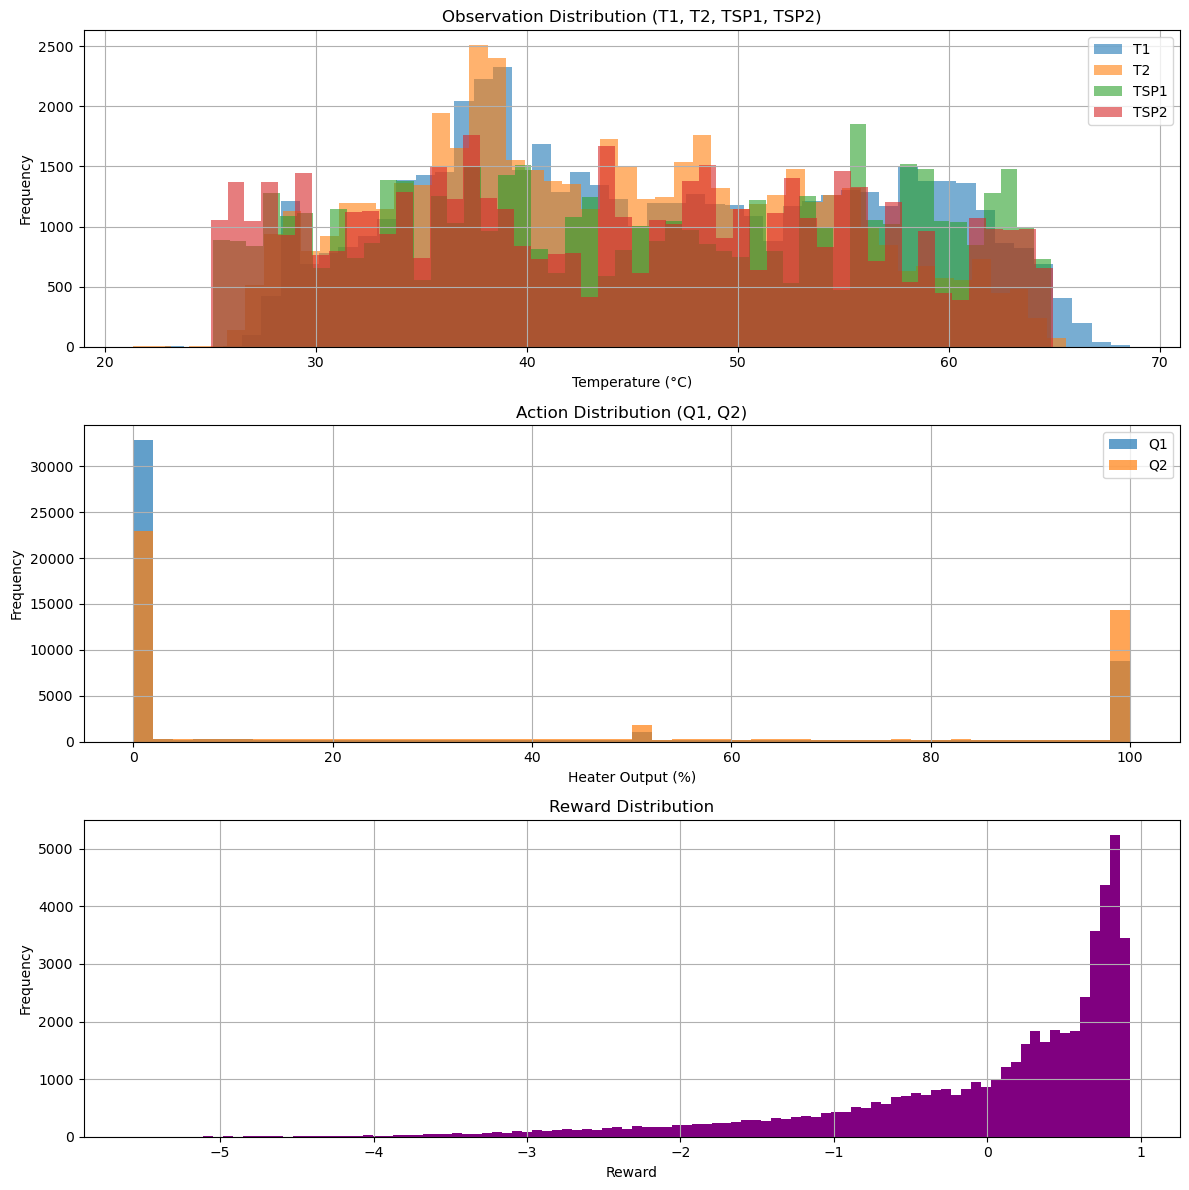

Reward mean: 4.737283e-09
Reward std: 1.0


In [23]:
# Re-import after kernel reset
import numpy as np
import matplotlib.pyplot as plt

# Reload dataset
data = np.load("C:/Users/Developer/TCLab/Data/MPC/second_reward.npz")
# C:\\Users\\Developer\\TCLab\\Data\\mpc_dataset.npz
# Extract components
observations = data["observations"]
actions = data["actions"]
rewards = data["rewards"]

# Plot settings
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

# 1. Observations (T1, T2, TSP1, TSP2)
axs[0].hist(observations[:, 0], bins=50, alpha=0.6, label="T1")
axs[0].hist(observations[:, 1], bins=50, alpha=0.6, label="T2")
axs[0].hist(observations[:, 2], bins=50, alpha=0.6, label="TSP1")
axs[0].hist(observations[:, 3], bins=50, alpha=0.6, label="TSP2")
axs[0].set_title("Observation Distribution (T1, T2, TSP1, TSP2)")
axs[0].set_xlabel("Temperature (°C)")
axs[0].set_ylabel("Frequency")
axs[0].legend()
axs[0].grid(True)

# 2. Actions (Q1, Q2)
axs[1].hist(actions[:, 0], bins=50, alpha=0.7, label="Q1")
axs[1].hist(actions[:, 1], bins=50, alpha=0.7, label="Q2")
axs[1].set_title("Action Distribution (Q1, Q2)")
axs[1].set_xlabel("Heater Output (%)")
axs[1].set_ylabel("Frequency")
axs[1].legend()
axs[1].grid(True)

# 3. Reward distribution
axs[2].hist(rewards, bins=100, color='purple')
axs[2].set_title("Reward Distribution")
axs[2].set_xlabel("Reward")
axs[2].set_ylabel("Frequency")
axs[2].grid(True)

plt.tight_layout()
plt.show()
print("Reward mean:", np.mean(rewards))
print("Reward std:", np.std(rewards))


In [20]:
from scipy.stats import shapiro, normaltest

# reward 불러오기
rewards = data["rewards"]

# 샘플 일부만 사용 (shapiro는 최대 5000개)
sampled_rewards = rewards[:5000]

# Shapiro-Wilk 검정
stat1, p1 = shapiro(sampled_rewards)
print(f"Shapiro-Wilk: stat={stat1:.4f}, p={p1:.4e}")

# D'Agostino and Pearson 검정
stat2, p2 = normaltest(rewards)
print(f"Normaltest: stat={stat2:.4f}, p={p2:.4e}")


Shapiro-Wilk: stat=0.8371, p=8.9153e-58
Normaltest: stat=15267.4176, p=0.0000e+00


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(rewards, kde=True, bins=100)
plt.title("Scaled Reward Distribution")
plt.grid(True)
plt.show()
